In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 
import os
import csv
import xlsxwriter

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu
import new_utils as newutils

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau
from scipy import ndimage

from glob import glob
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries
from scipy import spatial

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
from scipy.ndimage.morphology import binary_fill_holes, binary_closing
from skimage.measure import label as lb

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def plot_result( obj, frame, ax, imagedata=None ):
    if imagedata is None:
        ax.imshow(images[frame], plt.get_cmap('gray'))
    else:
        ax.imshow(imagedata[frame], plt.get_cmap('gray'))

    for oid in range(len(objects)):
        patches = [] # collects patches to be plotted
        surface = sampled_coords[obj][frame]
        polygon = Polygon(surface, True)
        patches.append(polygon)
        a = 0.2 + (float(oid)/len(objects))*0.6
        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=a, color='green')
        ax.add_collection(p)

In [3]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

<hr>

# Parameters

### Add the base path of the movies to be analyzed. It should contain
1) myosin channel with the name containing 'myosin' or 'Myosin'. <br>
2) membrane channel with the name containing 'membrane' or 'Membrane'.<br>
3) computed flow from GUI with the name containing 'flow' or 'Flow'.<br>
4) Labkit curated segmentation with the name containing 'labkit' or 'Labkit'<br>

*Very important:* The words myosin/membrane/flow/labkit should not be present in the file names except the corresponding file

In [4]:
base_path = '/Users/prakash/Downloads/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01/'

### Set all required parameters

Segmentation parameters:

In [5]:
seg_filter_size = 700 # Segmentations below this size will be filtered out 
Ea_centroid_this_frame = (225, 258) # Centroild of Ea cell for first time point
Ep_centroid_this_frame = (352, 234) # Centroild of Ep cell for first time point
min_radius = [(1,1), (1,1)] # Minimum radius from centroid from where the spyder legs should be drawn
max_radius = [(100,100), (100, 100)] # Maximum radius from centroid upto where the spyder legs should be drawn
num_columns = 150 # Number of spyder legs

Flow parameters:

In [6]:
annulus_outer_factor = .9 # The outer annulus as fraction of membarnbe segmentation for considering flows in this region
annulus_inner_factor = .4 # The inner annulus as fraction of membarnbe segmentation for considering flows in this region

Number crunching and plotting parameters:

In [7]:
use_EaEp_border_spyderlegs = False # If False, do not consider vectors on shared membrane between Ea and Ep for analysis. Consider all vectors if True

Ea_background_border = True # If False, assumes that Ea doesn't share border with background
use_Ea_background_spyderlegs = False # If False, do not consider vectors on membrane between Ea and background for analysis. Consider all vectors if True

Ep_background_border = False
use_Ep_background_spyderlegs = False

pixel_to_micron = 0.075962 # Microns per pixel
delta_t = 34.3/60 # Time between membrane acquistion
flow_threshold = 1.5 # microns/minute; Do not consider flow vectors if less than or equal to 'flow_threshold' value
set_flow_filter = True # set to True to filter flows, else set False
quiver_vector_scale = 200 # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer.

<hr>

# Processing

## Start reading filenames from input folder (defined above)

In [8]:
for file in os.listdir(base_path):
    if 'Membrane' in file or 'membrane' in file:
        fn_membrane = base_path + file
    if 'Myosin' in file or 'myosin' in file:
        fn_myosin = base_path + file
    if 'Flow' in file or 'flow' in file:
        fn_flow = base_path + file
    if 'Labkit' in file or 'labkit' in file:
        corrected_seg = base_path + file

In [9]:
segchannel = imread(fn_membrane)
flowchannel = imread(fn_myosin)

if(segchannel.ndim < 3): #Expects a 2D+t image
     raise 'Data dimensionality problem: please check imported data!'
elif(segchannel.ndim > 3):
    print("Membrane image has extra channel dimension, ignoring the extra dimension for analysis")
    segchannel = segchannel[...,0]
    
if(flowchannel.ndim < 3): #Expects a 2D+t image
     raise 'Data dimensionality problem: please check imported data!'
elif(flowchannel.ndim > 3):
    print("Flow image has extra channel dimension, ignoring the extra dimension for analysis")
    flowchannel = flowchannel[...,0]

sigma = [0.,2,2]
segchannel_smooth = segchannel
flowchannel_smooth = flowchannel
# segchannel_smooth = gaussian(segchannel,sigma)
# flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

gradientimage = segchannel_smooth

T = len(segchannel)-1  # number of time-points (last one is superfluous)
tempres_factor = int(len(flowchannel)/T)
print(tempres_factor)

if len(flowchannel)%T != 0:
    extra_frames = int(len(flowchannel)%T)
    print(str(extra_frames)+" extra flow frames detected, ignoring extra frames from end for analysis")
    flowchannel = flowchannel[:-extra_frames]
    flowchannel_smooth = flowchannel_smooth[:-extra_frames]
#     raise 'Tempres problem: please check imported data!'
else:
    print ('Tempres factor: %s'%tempres_factor)

print('Shape of membrane channel :', segchannel.shape)
print('Shape of flow channel:', flowchannel.shape)

Membrane image has extra channel dimension, ignoring the extra dimension for analysis
6
Tempres factor: 6
Shape of membrane channel : (5, 750, 430)
Shape of flow channel: (24, 750, 430)


### Sanity check: is the loaded data correct?

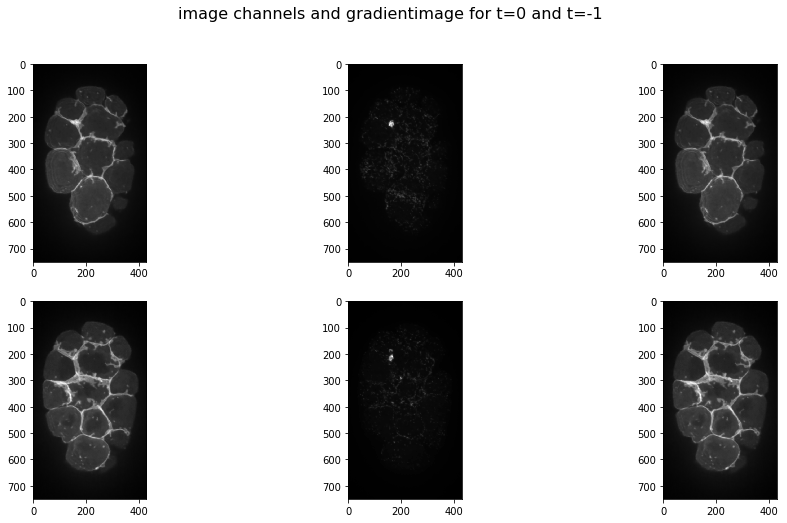

In [10]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
# fig.tight_layout()

# Cell segmentation and postprocessing

Load Labkit segmented images. The only consideration is that the segmentation should have closed(connected) components for Ea and Ep cells (or any other cell of interest). The segmented image should have different values for pixels belonging to cell, membrane and background. 
Labkit procedure: Use foreground label for membrane, background label for background and another label for cell interior. This specific label selection is important as it gives a particular label number to the segmented images which is used later in this notebook.

In [11]:
curated = imread(corrected_seg)
if(curated.ndim < 3): #Expects a 2D+t image
     raise 'Data dimensionality problem: please check imported data!'
elif(curated.ndim > 3):
    print("Labkit edited image has extra channel dimension, ignoring the extra dimension for analysis")
    curated = curated[...,0]

# curated = binary_fill_holes(curated)

The cell below identifies the label of the membrane in the Labkit edited images for using while computing statistics

In [12]:
y = np.bincount(curated[0].ravel())
ii = np.nonzero(y)[0]
a = list(zip(ii,y[ii]))
print(a)
min_num_pixels = 1000000000000000000000
fg_label = None
for pair in range(len(a)):
    num_pixels = a[pair][1]
    if(num_pixels<min_num_pixels):
        min_num_pixels = num_pixels
        fg_label = a[pair][0]
print("Membrane label in Labkit curated images:", fg_label)

[(1, 49750), (2, 181071), (3, 91679)]
Membrane label in Labkit curated images: 1


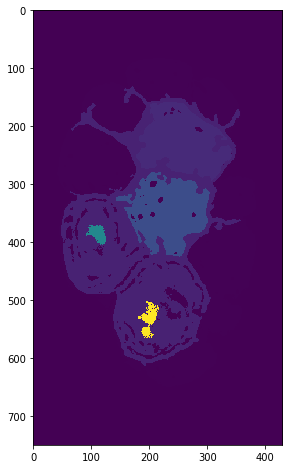

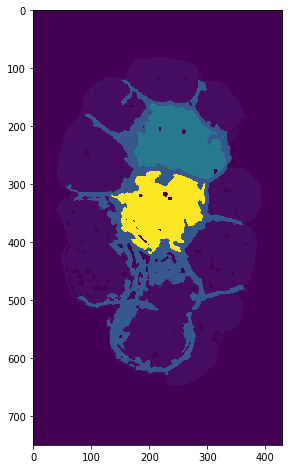

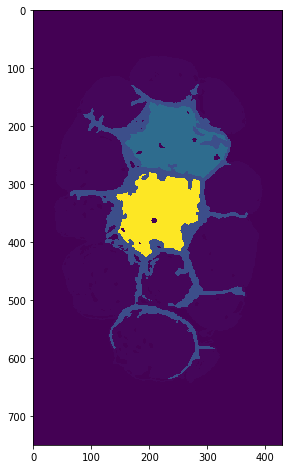

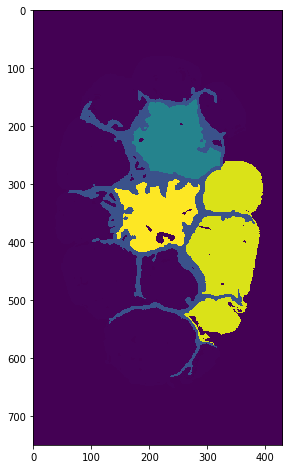

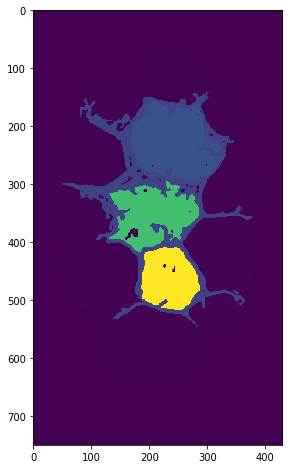

In [13]:
label_images_per_frame = []
# if not os.path.exists(base_path+'labeled_images'):
#     os.makedirs(base_path+'labeled_images')
for i in range(0,curated.shape[0]):
    labels_per_frame = lb(curated[i]).astype(np.uint32)
    label_size = []
    label_ids = []
    regions = regionprops(labels_per_frame)
    for props in regions:
        label_ids.append(props.label)
        label_size.append(props.area)
        for label_number in range(0, len(label_ids)): 
            if label_size[label_number] < seg_filter_size : # Filtering out components smaller than seg_filter_size pixels
                labels_per_frame[ labels_per_frame == label_ids[label_number] ] = labels_per_frame[0,0] # Replace isolated pixels with background label (assumption (0,0) is background in image) 
    
    label_images_per_frame.append(labels_per_frame)
#     imsave(base_path+"/labeled_images/Label"+str(i)+".tif", labels_per_frame)
    plt.imshow(labels_per_frame)
    plt.show()

In [14]:
bg_label = labels_per_frame[0,0] # The assumption is that the pixel at (0,0) is always background
#Seems to be the case in all the images that I have seen
#The background label from labeled images after doing connected components with regionprops, different from labkit labels

In [15]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=True )
objects = []
seeds = []

Add the identity(name) and approximate centroids of the cells of interest below. 

In [16]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
seeds.append(Ea_centroid_this_frame)

In [17]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
seeds.append(Ep_centroid_this_frame)

The cell below extracts the coordianets of all the pixels on the membrane of the cells of interest

In [18]:
unsampled_surface_coords = {}
query_centroids = {}
queried_labels = {}

for obj in range(len(objects)):
    
    seed = seeds[obj]
    object_centroids = []
    unsampled_surface_coords_per_object = []
    queried_labels_per_object = []
    
    for frame in range(0, curated.shape[0]):
        all_centroids_per_frame = []
        label_per_frame = []
        regions = regionprops(label_images_per_frame[frame])
        for props in regions:
            all_centroids_per_frame.append(props.centroid)
            label_per_frame.append(props.label)
        distance,index = spatial.KDTree(all_centroids_per_frame).query(seed)
        label_boundaries_per_frame = find_boundaries(label_images_per_frame[frame] == label_per_frame[index])
        surface_coord_per_frame = np.column_stack(np.where(label_boundaries_per_frame))
        surface_coord_per_frame = surface_coord_per_frame.tolist()
        surface_coord_per_frame = [tuple(l) for l in surface_coord_per_frame]

        unsampled_surface_coords_per_object.append(surface_coord_per_frame)

        seed = all_centroids_per_frame[index]
        
        object_centroids.append(seed)
        queried_labels_per_object.append(label_per_frame[index])
    
    
    unsampled_surface_coords[obj] = unsampled_surface_coords_per_object
    query_centroids[obj] = object_centroids
    queried_labels[obj] = queried_labels_per_object

In [19]:
queried_labels # Just for sanity check

{0: [21, 13, 20, 40, 61], 1: [41, 30, 14, 88, 167]}

*Note:* unsampled_surface_coords is inverted in x,y

In [20]:
col_vectors = newutils.sample_circle( num_columns )

In [21]:
# query_centroids[0][3] = (240, 395)
# query_centroids[0][10] = (350, 225)

# query_centroids[1][3] = (343, 218)
# query_centroids[1][6] = (307, 226)
# query_centroids[1][7] = (303, 247)
# query_centroids[1][8] = (304, 241)
# query_centroids[1][9] = (309, 223)


####---------------You are highly recommended to uncomment the following snippet too in case you run this cell-----######

# for cell in range(len(objects)):
#     for time in range(curated.shape[0]):
        
#         query_centroid_x = int(query_centroids[cell][time][0])
#         query_centroid_y = int(query_centroids[cell][time][1])
#         queried_label = label_images_per_frame[time][query_centroid_x][query_centroid_y]
#         if(queried_labels[cell][time] != queried_label):
#             print("Fixing query label for cell "+str(cell)+" at time "+ str(time))
#             queried_labels[cell][time] = queried_label
# print(queried_labels)

Fixing query label for cell 1 at time 2
{0: [21, 13, 20, 40, 61], 1: [41, 30, 55, 88, 167]}


**Note:** Execute the cell above only in case the cell below throws an error or if the segmentation looks weird (Explanation follows after segmemntation sanity check plots)!

This happens only if the center of mass of the segmented cell lies outside itself...

In [21]:
sampled_coords = {} #key: object_id, 
# value: dictionary with key: time, value: list of lists (coordinate matches along column with segmentation)
#Inner list is matches along each column id 
EaEp_boundary_column = {}
background_boundary_column = {}

for ob in range(len(objects)):
    sampled_coords[ob], EaEp_boundary_column [ob], background_boundary_column[ob] = newutils.get_coords(ob, curated.shape[0], num_columns,
                                                    query_centroids, col_vectors, min_radius, max_radius, 
                                                    label_images_per_frame, queried_labels, 
                                                    Ea_background_border, Ep_background_border, bg_label)

### Sanity check: is data segmented well?

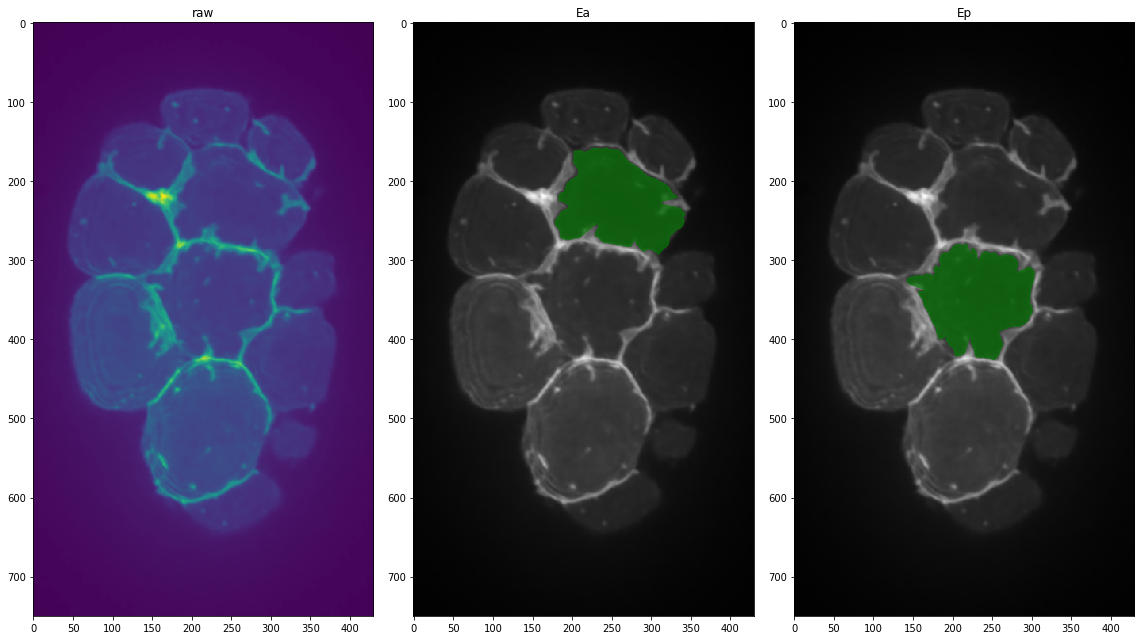

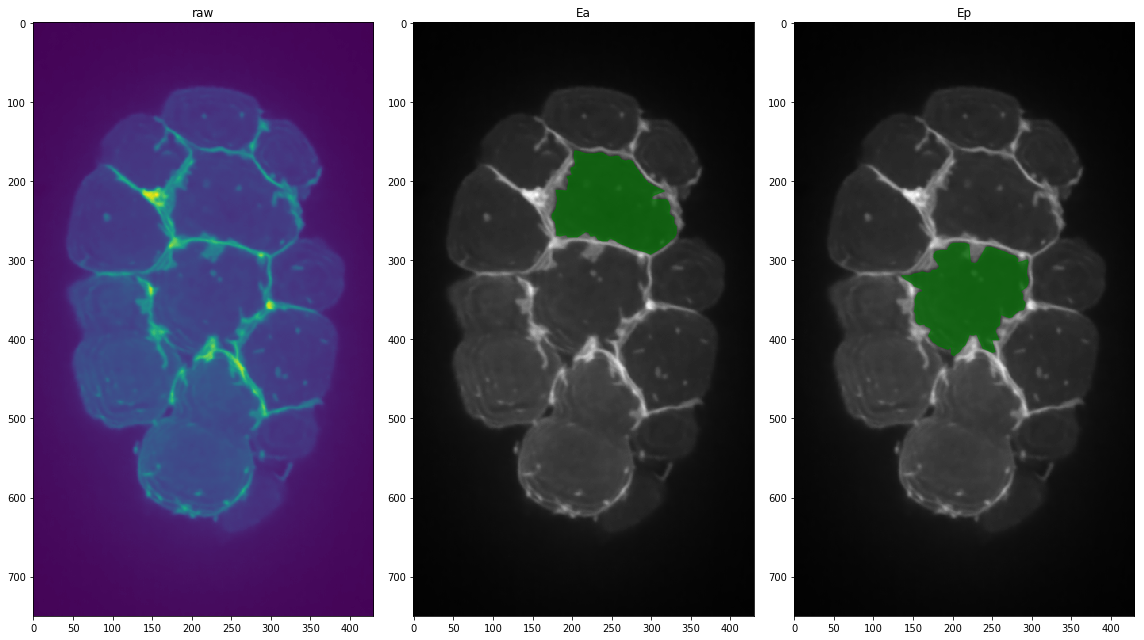

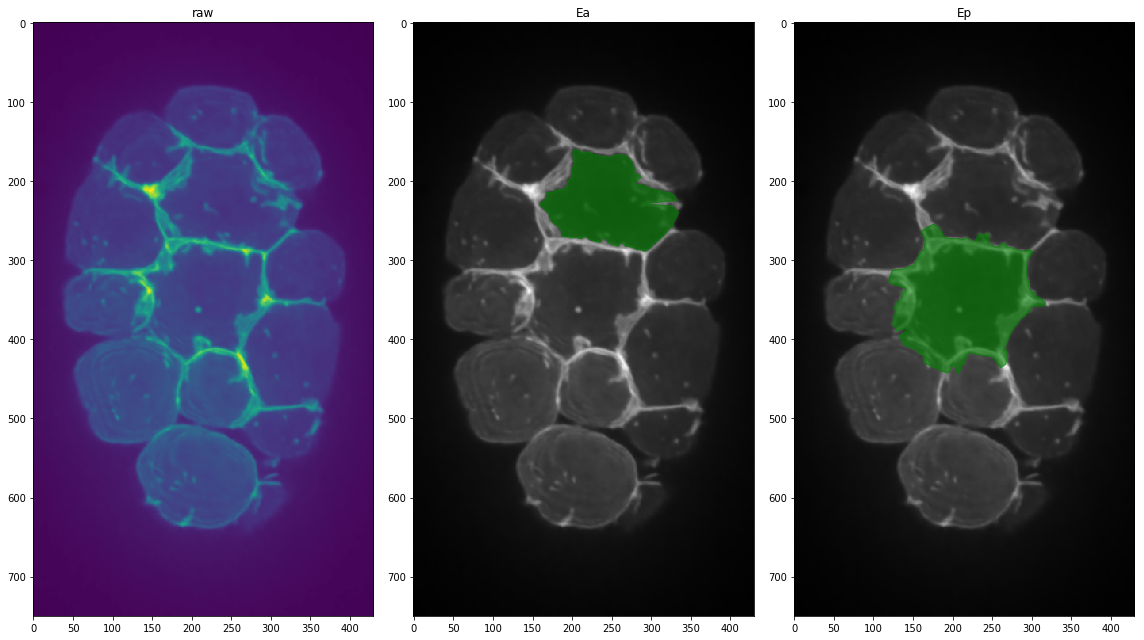

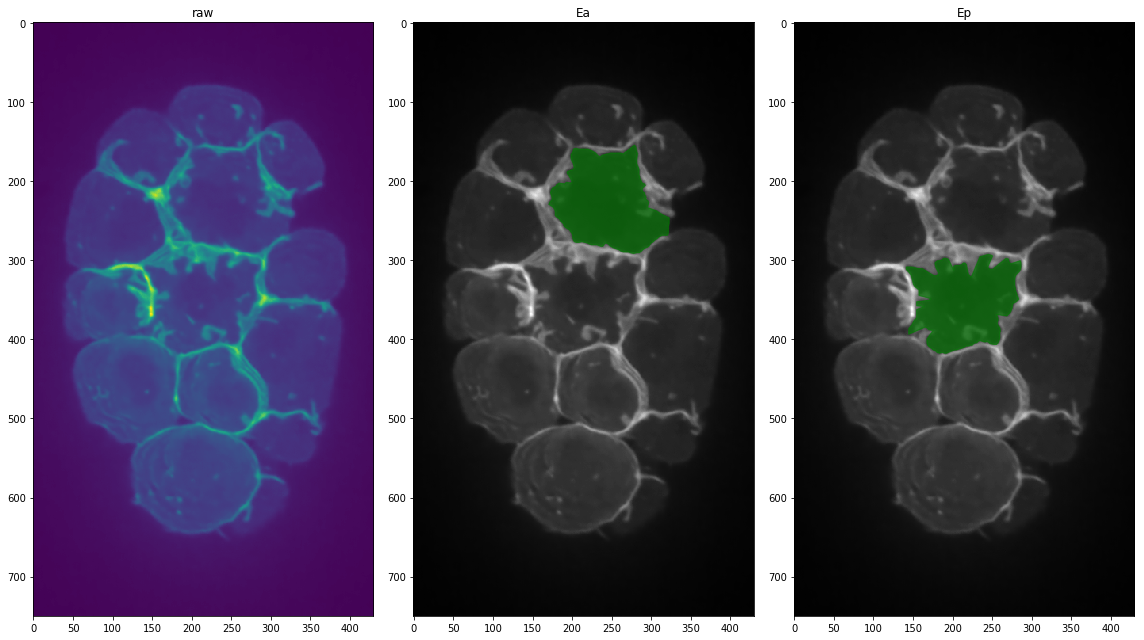

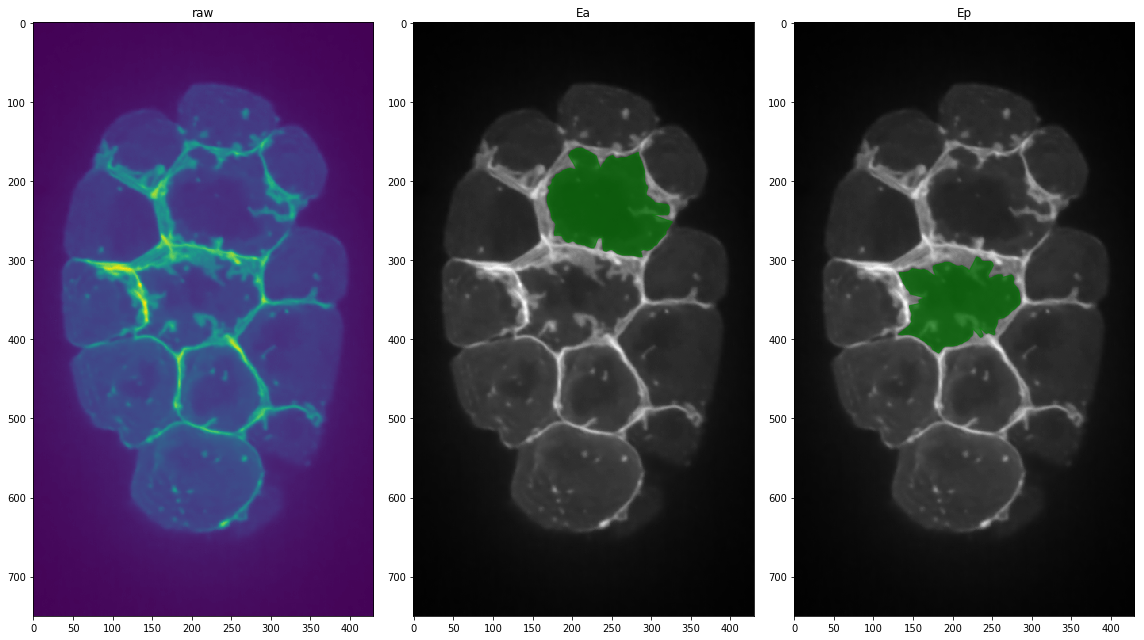

In [22]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(0,len(data.images)):
    fig = plt.figure()
    ax = plt.subplot(131)
    ax.set_title('raw')
    ax.imshow( segchannel_smooth[frame] )  
    ax = plt.subplot(132)
    ax.set_title('Ea')
    plot_result( 0, frame, ax, segchannel_smooth )  
    ax = plt.subplot(133)
    ax.set_title('Ep')
    plot_result( 1, frame, ax, segchannel_smooth )
    fig.tight_layout()

*Very important:* If the segmentations don't look right, it is very likely that one of the following things happened.<br>
1) The segmentations may not look right if they are too small, in which case the seg_filter_size should be reduced to account for these small segments)<br>
2) If the segments are large enough and still, the segmenations look inaccurate: The frame(s) for which segmentation looks inaccurate may have wrong centroids. In that case, please recenter the centroids for that frame and that cell and rerun that entire code snippet 

# Flow computation (taking higher frame-rate into account)

In [23]:
flows = imread(fn_flow) # Load the flow image stack saved from GUI
if(flows.ndim < 3): #Expects a 2D+t image
     raise 'Data dimensionality problem: please check imported data!'
elif(flows.ndim > 3):
    print("Computed flows has extra channel dimension, ignoring the extra dimension for analysis")
    flows = flows[...,0]
print(np.argwhere(np.isnan(flows)))

mask = np.isnan(flows)
flows[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), flows[~mask])

[[ 10 384 362]
 [ 11 384 362]]


In [24]:
flow_x = []
flow_y = []
for i in range(0,flows.shape[0],2):
    singleflow_x = flows[i]
    singleflow_y = flows[i+1]
    flow_x.append(singleflow_x)
    flow_y.append(singleflow_y)

flow_x = np.array(flow_x)
flow_y = np.array(flow_y)

In [25]:
avg_flow_x = bsu.flow_merge_frames(flow_x, tempres_factor)
avg_flow_y = bsu.flow_merge_frames(flow_y, tempres_factor)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

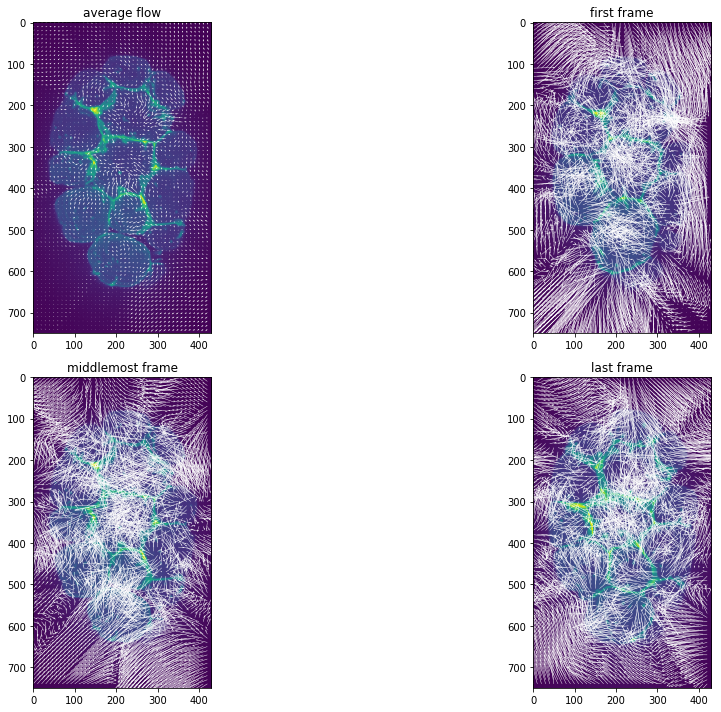

In [26]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale = 50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(segchannel)/2)][skip],-avg_flow_y[int(len(segchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
# fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [27]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T+1):
        
        membrane_polygones.append( newutils.get_polygone_points(obj, t, sampled_coords, query_centroids, 1) )
        annulus_outer_polygones.append( newutils.get_polygone_points(obj, t, sampled_coords, query_centroids, annulus_outer_factor) )
        annulus_middle_polygones.append( newutils.get_polygone_points(obj, t, sampled_coords, query_centroids,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( newutils.get_polygone_points(obj, t, sampled_coords, query_centroids, annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

### Sanity check: are annuli set sensibly?

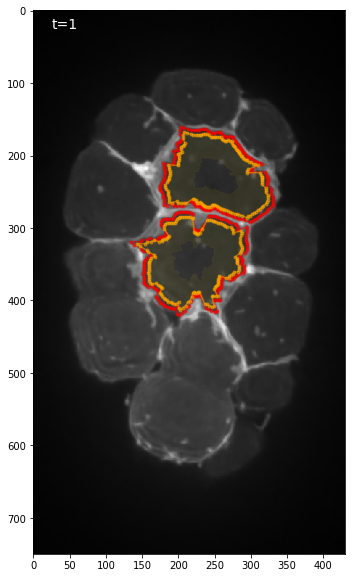

In [28]:
t = 1
fig = plt.figure()
ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

for obj in objects:
    
    poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
    poly_membrane2 = geometry.Polygon(annulus_outer_polygones_per_object[obj][t])
    poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
    patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
    ax.add_patch(patch_annulus)
    plot_coords( ax, poly_membrane.exterior, 'red', alpha=.5 )
    plot_coords( ax, poly_membrane2.exterior, 'orange', alpha=.5 )


In [29]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = newutils.get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [30]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:

    membrane_movement_vectors_per_frame = []
    for t in range(T):
        membrane_movement_vectors = []

        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        
        for i in range(len(poly_t2)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [31]:
column_vectors = col_vectors # they are normalized to length 1

Until now, we averaged the intermediate myosin frames to get one myosin frame corresponding to each membrane frame (and also to clean up noisy flows). In the next cell, we will go through each pixel on the Spyder legs between two annuli and ignore those flow vectors whose component (absolute value) in the direction of corresponding Spyder leg is less than a particular threshold value set in parameters section. In the cells after next cell, we will average the projected components of only the remaining flows along any Spyder leg to get the average flow (scalar) for each Spyder leg

In [32]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    s = 0
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            effective_num = 0
            for point in line:
                x_comp = avg_flow_x[t,int (point[1]),int(point[0])]
                y_comp = avg_flow_y[t,int(point[1]),int(point[0])]
                if(set_flow_filter):
                    effective_vel = newutils.post_avg_flow_filter(x_comp, y_comp, column_vectors[l], pixel_to_micron, delta_t)
                    if(abs(effective_vel)< flow_threshold):
                        continue
                    else:
                        sum_x += x_comp
                        sum_y += y_comp
                        effective_num+=1
                else:
                    sum_x += x_comp
                    sum_y += y_comp
                    effective_num+=1
                
            if(effective_num>0):
                avg_x = sum_x/effective_num
                avg_y = sum_y/effective_num
            else:
                avg_x = 0
                avg_y = 0
           
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [33]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### remove vectors with average flow less than flow_threshold from analysis if set_flow_filter=True

In [34]:
if(set_flow_filter):
    for obj in objects:
        for t in range(T):
            for cols in range(num_columns):
                if(projected_avg_flows_per_frame_per_object[obj][t][cols] == 0):
                    projected_avg_flows_per_frame_per_object[obj][t][cols] = 0
                    projected_mem_vecs_per_frame_per_object[obj][t][cols] = 0

### remove shared boundary vectors from analysis

This happens only if use_all_spyderlegs is set to False

In [35]:
projected_avg_flows_per_frame_per_object = projected_avg_flows_per_frame_per_object
projected_mem_vecs_per_frame_per_object = projected_mem_vecs_per_frame_per_object
if(use_EaEp_border_spyderlegs is False):
    for obj in objects:
        for t in range(T):
            for cols in EaEp_boundary_column[obj][t]:
                projected_avg_flows_per_frame_per_object[obj][t][cols] = 0
                projected_mem_vecs_per_frame_per_object[obj][t][cols] = 0

if(Ea_background_border):
    if(use_Ea_background_spyderlegs is False):
        for t in range(T):
            for cols in background_boundary_column[0][t]:
                projected_avg_flows_per_frame_per_object[0][t][cols] = 0
                projected_mem_vecs_per_frame_per_object[0][t][cols] = 0
                
if(Ep_background_border):
    if(use_Ep_background_spyderlegs is False):
        for t in range(T):
            for cols in background_boundary_column[1][t]:
                projected_avg_flows_per_frame_per_object[1][t][cols] = 0
                projected_mem_vecs_per_frame_per_object[1][t][cols] = 0

###### The following cell computes the slippage in microns/min for each Spyder leg for each object (Ea and Ep) for each time point and writes it in a xlsx file. Note that the Spyder legs corresponding to the background and cell borders and the common borders between Ea and Ep will be written as zero if the use_Ea_background_spyderlegs and use_Ea/Ep_border_spyderlegs are set as False.

In [36]:
# Create a workbook and add worksheets.
if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
workbook = xlsxwriter.Workbook(base_path+'results/slippage_per_spyderleg.xlsx')
for obj in objects:
    if(obj == 0):
        worksheet = workbook.add_worksheet("Ea")
    if(obj == 1):
        worksheet = workbook.add_worksheet("Ep")
    bold = workbook.add_format({'bold': 1})
    # Adjust the column width.
    worksheet.set_column(1, 1, 15)
    legs = np.arange(num_columns)
    row = 0
    col = 1
    worksheet.write('', 'time(frame)', bold)
    for j, leg in enumerate(legs):
        worksheet.write(row, col + j, leg, bold)
    # Start from the first cell below the headers.
    row = 1
    for t in range(T):
        col = 0
        worksheet.write_number(row, col, t)
        slip = [a_i - b_i for a_i, b_i in zip(projected_avg_flows_per_frame_per_object[obj][t], projected_mem_vecs_per_frame_per_object[obj][t])]
        slip_vel = [ele*pixel_to_micron for ele in slip]
        values_row = [x/(delta_t) for x in slip_vel]
        for value in values_row: 
            col = col+1
            worksheet.write(row, col, value )
        row = row + 1
workbook.close()

### compute frame averages for lineplots

In [37]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
slippage_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    slippage_per_frame = []
    for t in range(T):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        nonzero_mem_contraction = np.sum(memveclengths)/(np.count_nonzero(np.array(memveclengths))+1e-10)
        nonzero_flow = np.sum(flowveclengths)/(np.count_nonzero(np.array(flowveclengths))+1e-10)
        avg_membrane_contraction_per_frame.append(nonzero_mem_contraction)
        avg_center_flow_per_frame.append(nonzero_flow)
        slippage_per_frame.append( nonzero_flow - nonzero_mem_contraction )
                
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    slippage_per_frame_per_object.append( slippage_per_frame )

# Plotting crunched flow data

The cell below plots average flow, average membrane and slippage in pixels with time in frames. Additionally, we also have plots to see the flow and membrane vectors. In blue, is the membrane outline at the current time point while in green the membrane outline at next time point. The membrane movement vectors are plotted in blue while the flow vectors are plotted in yellow along each column.

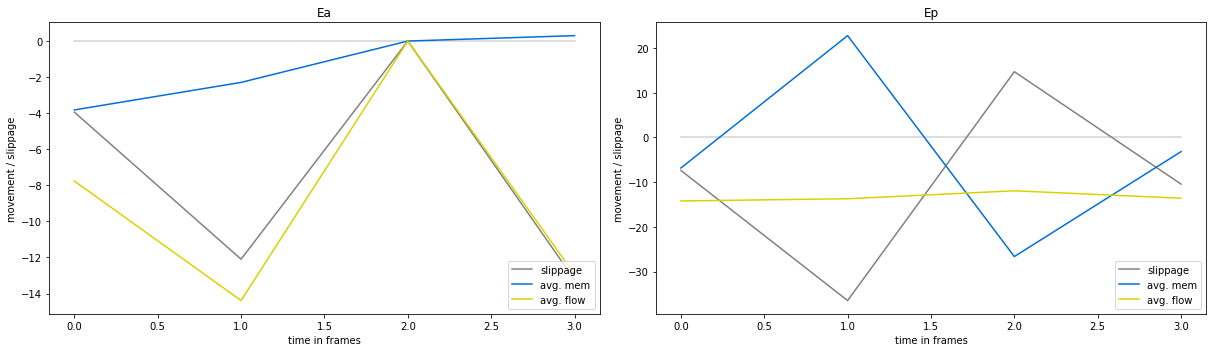

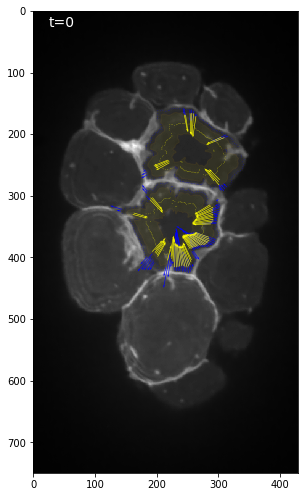

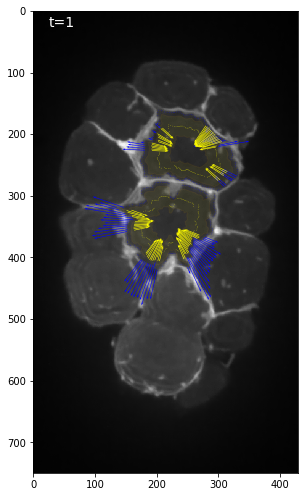

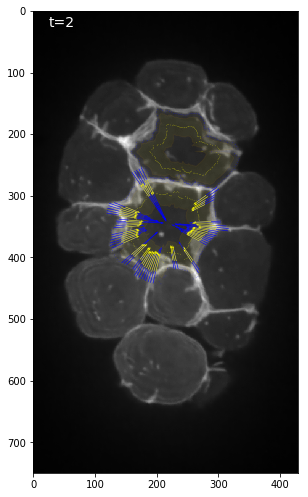

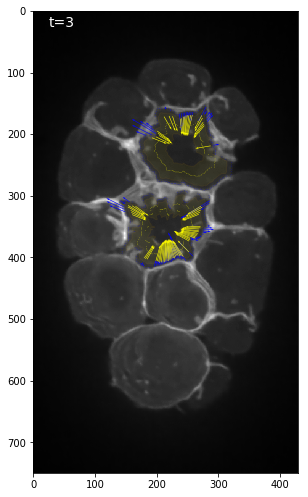

In [39]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time in frames')
ax.set_ylabel('movement / slippage')
ax.plot(np.zeros_like(slippage_per_frame_per_object[0]), color='lightgray')
ax.plot(slippage_per_frame_per_object[0], color='gray', label='slippage')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)

ax.set_title(data.object_names[1])
ax.set_xlabel('time in frames')
ax.set_ylabel('movement / slippage')
ax.plot(np.zeros_like(slippage_per_frame_per_object[1]), color='lightgray')
ax.plot(slippage_per_frame_per_object[1], color='gray', label='slippage')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()
if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
fig.savefig(base_path+'results/pixels_per_frame_velocity.png')

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(0,len(segchannel)-1,1):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(query_centroids[obj][t+1][1],query_centroids[obj][t+1][0], 'o', color='green')
        ax.plot(query_centroids[obj][t][1],query_centroids[obj][t][0], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

         # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=quiver_vector_scale, color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x, 
                  flow_base_y, 
                  flow_vec_x, 
                  flow_vec_y, 
                  pivot='mid', width=0.0022, scale=quiver_vector_scale, color='yellow')
        
    if not os.path.exists(base_path+'results'):
        os.makedirs(base_path+'results')
    fig.savefig(base_path+'results/vector_plot_time'+str(t)+'.png')  
    fig.tight_layout()

Compute the areas of the cells at different times and plot them 

In [40]:
area_per_object = []
for obj in objects:
    area_per_frame = []
    for frame in range(T+1):
        poly_mem = geometry.Polygon(membrane_polygones_per_object[obj][frame])
        area_per_frame.append(poly_mem.area)
    area_per_object.append(area_per_frame)

In [41]:
time_axes = []
time_axes.append(delta_t)

for time in range(T-1):
    time_elapsed = time_axes[-1]
    time_axes.append(time_elapsed+delta_t)
time_axes = [0] + time_axes

The plot below shows how the membrane area (micron_squared) changes over time(in minutes) for Ea and Ep and writes the areas for corresponding cells with time indices in a csv file in the results folder

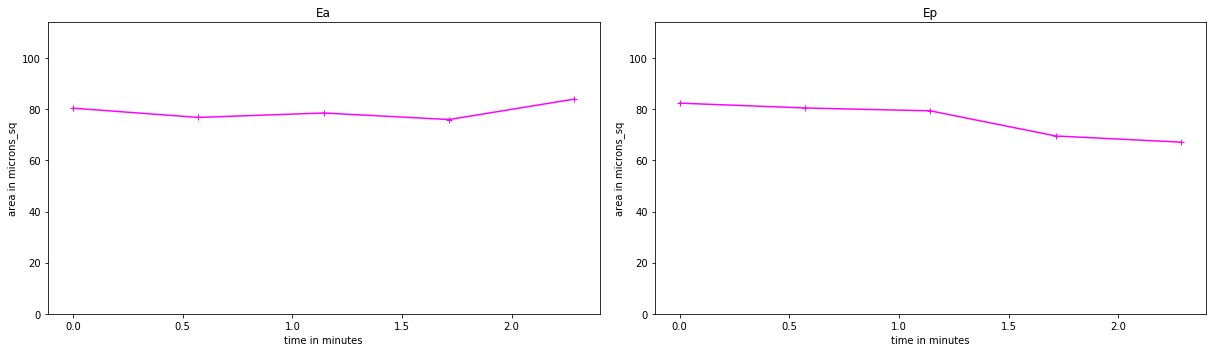

In [42]:
max_value, _ = max((x, (i, j))
                           for i, row in enumerate(area_per_object)
                           for j, x in enumerate(row)) # finds the maximum area among all cells and all times
ymax = max_value*pixel_to_micron*pixel_to_micron +30
# ymax = 200
ymin = 0
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()

if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
workbook = xlsxwriter.Workbook(base_path+'results/area.xlsx')
for obj in objects:
    if(obj == 0):
        worksheet = workbook.add_worksheet("Ea")
    if(obj == 1):
        worksheet = workbook.add_worksheet("Ep")
    bold = workbook.add_format({'bold': 1})
    # Adjust the column width.
    worksheet.set_column(1, 1, 15)
    row = 0
    col = 0
    worksheet.write(row, col, 'time(minutes)', bold)
    worksheet.write(row, col+1, 'area(microns_square)')
    ax = fig.add_subplot(1,2,obj+1)
    ax.set_title(data.object_names[obj])
    ax.set_xlabel('time in minutes')
    ax.set_ylabel('area in microns_sq')
    area_in_microns_sq = [ele*pixel_to_micron*pixel_to_micron for ele in area_per_object[obj]]
    ax.plot(time_axes, area_in_microns_sq, color='magenta', marker = '+')
    ax.set_ylim((ymin, ymax))
    
    row = 1
    for idx in range(len(area_in_microns_sq)):
        col = 0
        value = [time_axes[idx], area_in_microns_sq[idx]]
        worksheet.write(row, col, value[0] )
        worksheet.write(row, col+1, value[1] )
        row = row+1
            
plt.tight_layout()
plt.show()
fig.savefig(base_path+'results/area.png')
workbook.close()

The plot generated below shows the average flow, average membrane and slippage in microns with time in minutes.

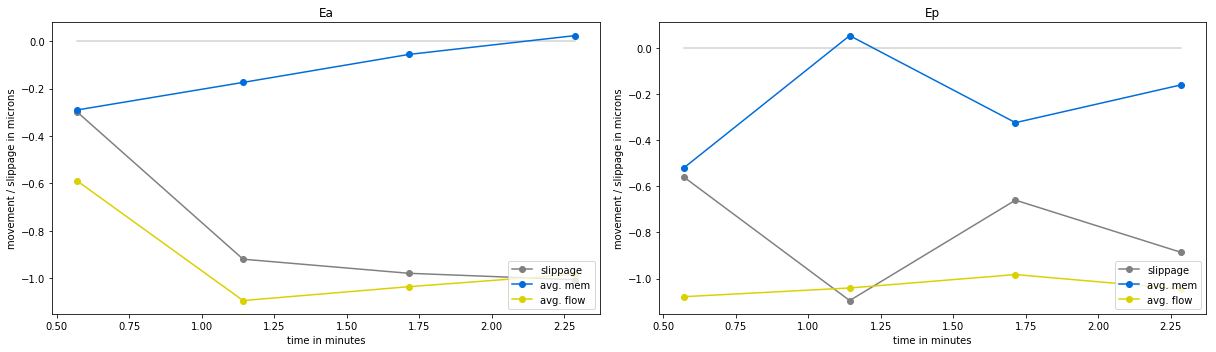

In [43]:
slippage_Ea = [ele*pixel_to_micron for ele in slippage_per_frame_per_object[0]]
avg_membrane_contraction_Ea = [ele*pixel_to_micron for ele in avg_membrane_contraction_per_frame_per_object[0]]
avg_center_flow_Ea = [ele*pixel_to_micron for ele in avg_center_flow_per_frame_per_object[0]]

slippage_Ep = [ele*pixel_to_micron for ele in slippage_per_frame_per_object[1]]
avg_membrane_contraction_Ep = [ele*pixel_to_micron for ele in avg_membrane_contraction_per_frame_per_object[1]]
avg_center_flow_Ep = [ele*pixel_to_micron for ele in avg_center_flow_per_frame_per_object[1]]

pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time in minutes')
ax.set_ylabel('movement / slippage in microns')
ax.plot(time_axes[1:], np.zeros_like(slippage_per_frame_per_object[0]), color='lightgray')
ax.plot(time_axes[1:], slippage_Ea, color='gray', label='slippage', marker ='o')
ax.plot(time_axes[1:], avg_membrane_contraction_Ea, color='#%02x%02x%02x'%(0,109,219), label='avg. mem', marker ='o')
ax.plot(time_axes[1:], avg_center_flow_Ea, color='#%02x%02x%02x'%(219,209,0), label='avg. flow', marker ='o')
ax.legend( loc='lower right')

ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time in minutes')
ax.set_ylabel('movement / slippage in microns')
ax.plot(time_axes[1:], np.zeros_like(slippage_per_frame_per_object[1]), color='lightgray')
ax.plot(time_axes[1:], slippage_Ep, color='gray', label='slippage', marker ='o')
ax.plot(time_axes[1:], avg_membrane_contraction_Ep, color='#%02x%02x%02x'%(0,109,219), label='avg. mem', marker ='o')
ax.plot(time_axes[1:], avg_center_flow_Ep, color='#%02x%02x%02x'%(219,209,0), label='avg. flow', marker ='o')
ax.legend( loc='lower right')
fig.tight_layout()
if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
fig.savefig(base_path+'results/velocity_proxy.png')

In [44]:
slippage_velocity_Ea = [x/(delta_t) for x in slippage_Ea]
avg_flow_velocity_Ea = [x/(delta_t) for x in avg_center_flow_Ea]
slippage_velocity_Ep = [x/(delta_t) for x in slippage_Ep]
avg_flow_velocity_Ep = [x/(delta_t) for x in avg_center_flow_Ep]

Writes slippage rates in microns/minute with time indices for differnt cells as csv file in results folder. The sign of slippage velocity indicates direction with -ve being inwards and vice-versa.

In [45]:
if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
workbook = xlsxwriter.Workbook(base_path+'results/slippage_rates_overall.xlsx')
for obj in objects:
    if(obj == 0):
        worksheet = workbook.add_worksheet("Ea")
    if(obj == 1):
        worksheet = workbook.add_worksheet("Ep")
    bold = workbook.add_format({'bold': 1})
    # Adjust the column width.
    worksheet.set_column(1, 1, 15)
    row = 0
    col = 0
    worksheet.write(row, col, 'time(minutes)', bold)
    worksheet.write(row, col+1, 'slippage velocity(microns/minute)')

    if(obj == 0):    
        row = 1
        for ele in range(1,len(time_axes)):
            col = 0
            value = [time_axes[ele], slippage_velocity_Ea[ele-1]]
            worksheet.write(row, col, value[0] )
            worksheet.write(row, col+1, value[1] )
            row = row+1
    if(obj == 1):    
        row = 1
        for ele in range(1,len(time_axes)):
            col = 0
            value = [time_axes[ele], slippage_velocity_Ep[ele-1]]
            worksheet.write(row, col, value[0] )
            worksheet.write(row, col+1, value[1] )
            row = row+1
workbook.close()

The plot below shows the myosin velocity and slippage velocity in microns/minute at different time points(time points where membrane acquisition was made). The sign of slippage velocity indicates direction with -ve being inwards and vice-versa.

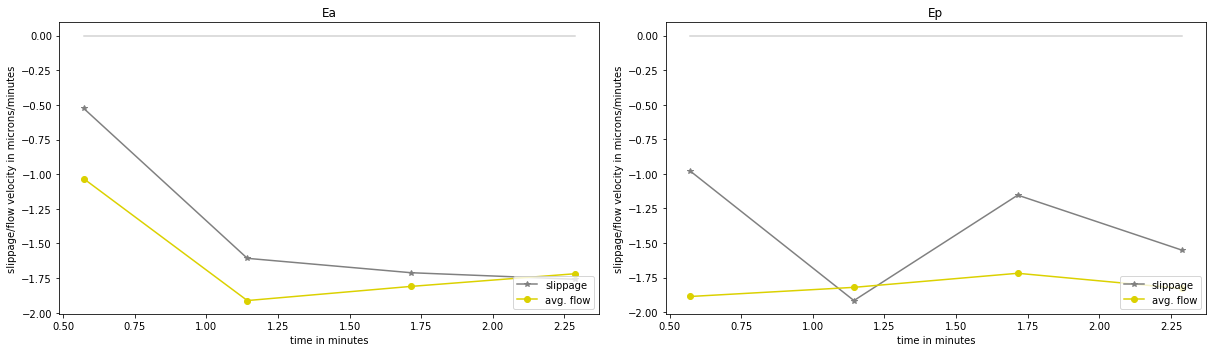

In [46]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time in minutes')
ax.set_ylabel('slippage/flow velocity in microns/minutes')
ax.plot(time_axes[1:], np.zeros_like(slippage_per_frame_per_object[0]), color='lightgray')
ax.plot(time_axes[1:], slippage_velocity_Ea, color='gray', label='slippage', linestyle = '-', marker = '*')
ax.plot(time_axes[1:], avg_flow_velocity_Ea, color='#%02x%02x%02x'%(219,209,0), label='avg. flow', linestyle = '-', marker = 'o')
ax.legend( loc='lower right')

ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time in minutes')
ax.set_ylabel('slippage/flow velocity in microns/minutes')
ax.plot(time_axes[1:], np.zeros_like(slippage_per_frame_per_object[1]), color='lightgray')
ax.plot(time_axes[1:], slippage_velocity_Ep, color='gray', label='slippage', linestyle = '-', marker = '*')
ax.plot(time_axes[1:], avg_flow_velocity_Ep, color='#%02x%02x%02x'%(219,209,0), label='avg. flow', linestyle = '-', marker = 'o')
ax.legend( loc='lower right')
fig.tight_layout()

if not os.path.exists(base_path+'results'):
    os.makedirs(base_path+'results')
fig.savefig(base_path+'results/velocity')